# DS 4440: HW2

In this homework we implement backprop the ''hard way'', but only for a simple MLP network, so it's not too painful. We'll play around looking at the gradients for hidden states with and without ``NNSight``.

In [1]:
import numpy as np # NumPy only!
import random

## Q1. Implement the MLP class (*40 points*)

Design a Multi-Layer Perceptron (MLP) with two layers: one hidden layer and one output layer. Use the sigmoid activation function for the hidden and output layers, and apply Mean Squared Error (MSE) as the loss function

In [2]:
def sigmoid(x):
    # Your code here
    z = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-z))

def BCE(y_hat, y):
    return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

class MLP:
    def __init__(self, input_size, hidden_dims=32, alpha=0.2):
        '''
        Instantiate a single-layer feedforward MLP with the given parameters.

        \alpha is the learning rate.
        '''
        self.input_size = input_size
        self.hidden_dims = hidden_dims
        self.initialize_weights()
        self.activation = sigmoid
        self.alpha = alpha # learning rates

    def initialize_weights(self):
        '''
        Instantiate all model parameters (weights). Specifically, set these to
        (uniformly) randomly sampled values from range (-1, 1).
        '''
        # Your code here
        self.W1 = np.random.uniform(-1, 1, (self.input_size, self.hidden_dims))
        self.W2 = np.random.uniform(-1, 1, (self.hidden_dims, 1))
        self.b1 = np.random.uniform(-1, 1, (1, self.hidden_dims))
        self.b2 = np.random.uniform(-1, 1, (1, 1))

    def forward(self, X):
        '''
        Make a forward pass through the network.
        '''
        if X.ndim == 1:
          X = X.reshape(1, -1)
        assert (X.shape[1] == self.input_size)
        # Your code here
        h = np.dot(X, self.W1) + self.b1
        h = self.activation(h)
        y_hat = sigmoid(np.dot(h, self.W2) + self.b2)
        return h, y_hat


    def predict(self, X):
        '''
        Convienence function to yield a prediction for a given input.
        Assumes X has shape (num instances x input size); outputs a
        vector of *binary* predictions for each instance.
        '''
        # Your code here
        _, y_hat = self.forward(X)
        return (y_hat >= 0.5).astype(int)


    def backprop(self, X, y, verbose=False):
        '''
        Given input X and (true) label y, take forward pass with current
        model parameters, backprop this, and adjust model parameters
        accordingly.
        '''
        # Your code here
        # Forward pass
        h, y_hat = self.forward(X)
        # Compute gradients
        local_error = (y_hat - y)
        layer2_output_grad = local_error * y_hat * (1 - y_hat)
        grad_h = np.dot(layer2_output_grad, self.W2.T)
        layer1_output_grad = grad_h * h * (1 - h)
        # Reshape X to 2D if it's a single instance
        if X.ndim == 1:
            X = X.reshape(1, -1)

        # Update parameters
        self.W2 -= self.alpha * np.dot(h.T, layer2_output_grad)
        self.b2 -= self.alpha * np.sum(layer2_output_grad, axis=0)
        self.W1 -= self.alpha * np.dot(X.T, layer1_output_grad)
        self.b1 -= self.alpha * np.sum(layer1_output_grad, axis=0)

    def fit(self, X, y, epochs, verbose=True):
        '''
        Train the model for the specified number of epochs.
        '''
        accs, losses = [], []
        for e in range(epochs):
            if verbose:
              print ("on epoch {}".format(e))

            correct = 0
            loss = 0
            for i in range(X.shape[0]):
                h, y_hat = self.forward(X[i])
                y_hat = y_hat.squeeze()
                y_hat_bin = int(y_hat >= .5)
                if y_hat_bin == y[i]:
                    correct += 1
                loss += BCE(y_hat, y[i])
            acc = correct / X.shape[0]
            accs.append(acc)
            losses.append(loss)
            if verbose:
              print("accuracy: {:.2f}; loss: {:.2f}".format(acc, loss))

            for i in range(X.shape[0]):
                self.backprop(X[i], y[i])

        return accs, losses

## Q2 Exploring the bias-variance trade-off (*20 points*)

You should:

*  Use sklearn `make_classification` to create a simple dataset comprising 1000 samples
* Split this into equal sized disjoint train and test sets.
* Instantiate your MLP

#### A) Plot train and test performance as a function of epochs
#### B) See how additional dimensions affect train and test performance

#### A.
Using `matplotlib` (see [here](https://https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=08RTGn_xE3MP)), plot train and test performances as a function of epochs

In [3]:
# your code
import numpy as np
import sklearn.datasets as skd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

data, label = skd.make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X, y = data, label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_epochs_max = 100

model = MLP(X_train.shape[1])
train_accs, train_loss = model.fit(X_train, y_train, epochs=n_epochs_max, verbose=False)

train_predictions = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

test_accs, test_loss = model.fit(X_test, y_test, epochs=n_epochs_max, verbose=False)
test_predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)

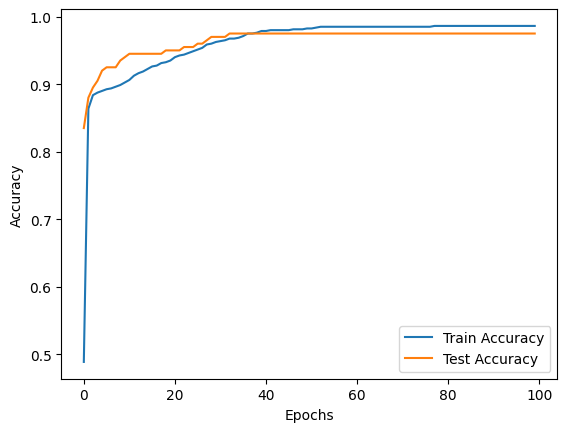

In [4]:
# Example plot result; obviously you don't need to use these var
# names, etc. Just meant to be illustrative.
plt.plot(range(n_epochs_max), train_accs, label="Train Accuracy")
plt.plot(range(n_epochs_max), test_accs, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### B.
Let's see how additional hidden dims affect this (if at all). Define two MLPs (using your implementation!), one with hidden dimension size 16, one with hidden dimension size 128. Use the same learning rate for both. Train both for up to 200 epochs, recording the resultant accuracy on both the train and test sets.

In [5]:
n_epochs_max = 200

# Your code here
m16 = MLP(X_train.shape[1], hidden_dims=16)
m128 = MLP(X_train.shape[1], hidden_dims=128)

train_accs16, train_loss16 = m16.fit(X_train, y_train, epochs=n_epochs_max, verbose=False)
train_predictions16 = m16.predict(X_train)
test_accs16, test_loss16 = m16.fit(X_test, y_test, epochs=n_epochs_max, verbose=False)
test_predictions16 = m16.predict(X_test)

train_accs128, train_loss128 = m128.fit(X_train, y_train, epochs=n_epochs_max, verbose=False)
train_predictions128 = m128.predict(X_train)
test_accs128, test_loss128 = m128.fit(X_test, y_test, epochs=n_epochs_max, verbose=False)
test_predictions128 = m128.predict(X_test)

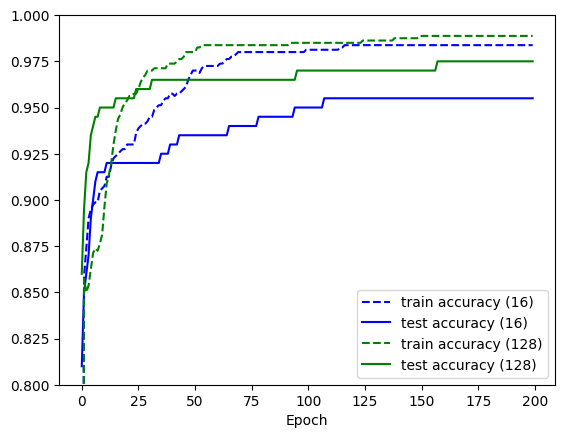

In [6]:
plt.plot(range(n_epochs_max), train_accs16, color="blue", ls="--", label="train accuracy (16)")
plt.plot(range(n_epochs_max), test_accs16, color="blue", ls="-", label="test accuracy (16)")
plt.plot(range(n_epochs_max), train_accs128, color="green", ls="--", label="train accuracy (128)")
plt.plot(range(n_epochs_max), test_accs128, color="green", ls="-", label="test accuracy (128)")
plt.xlabel("Epoch")
plt.ylim((0.8, 1))
plt.legend()

So we can see the overfitting is more pronounced when we have more dimensions (free parameters).

Your plot won't *necessarily* show this, though it probably should.

## Q3. Test the Implementation (*10 points*)

You should:

* Instantiate your MLP and fit to the train data
* Instantiate the MLP defined in `sklearn.neural_network.MLP` (using same hyperparameters!) and fit to the train data.
* Make predictions for the test dataset using both models, generate metrics using `classification_report` from `sklearn`.
* Assert that these models achieve comparable results (**Hint** the MLP may be sensitive to the number of epochs -- as per the following question.)



In [7]:
# Your code here
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

model = MLP(X_train.shape[1])
model.fit(X_train, y_train, epochs=1000, verbose=False)
y_pred = model.predict(X_test)
print("My MLP\n", classification_report(y_test, y_pred))

sklearn = MLPClassifier(hidden_layer_sizes=(32,), max_iter=1000, alpha=0.2, random_state=42)
sklearn.fit(X_train, y_train)
y_pred = sklearn.predict(X_test)
print("SKLearn MLP\n", classification_report(y_test, y_pred))

My MLP
               precision    recall  f1-score   support

           0       0.79      0.85      0.82        93
           1       0.86      0.80      0.83       107

    accuracy                           0.82       200
   macro avg       0.82      0.83      0.82       200
weighted avg       0.83      0.82      0.83       200

SKLearn MLP
               precision    recall  f1-score   support

           0       0.82      0.86      0.84        93
           1       0.87      0.83      0.85       107

    accuracy                           0.84       200
   macro avg       0.84      0.85      0.84       200
weighted avg       0.85      0.84      0.85       200



# Q4. Activation gradients with (and without) ``NNSight`` (*30 points*)

Now, let's say we wanted to take a deeper look at the gradients of the hidden layer, to try to understand what the network was doing internally and what it was "learning". In particular, for a given $(X, y)$ you would like to be able to extract the gradient for the hidden layer and store this.

How would you modify your `MLP` class above to facilitate this? Provide a one sentence description of how you'd do this.

I would make my MLP class iterate over each epoch in the learning/training process so that values from each step can be taken/used.

Fortunately, you don't have to! We can use ``NNSight`` to easily access this, so long as we write our model in `torch`. Let's do this.

In [8]:
!pip install nnsight

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Owner\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


First build the same model in `torch`, wrap it in `NNsight`.

In [9]:
from collections import OrderedDict
import torch
from nnsight import NNsight
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

hidden_dims = 16

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i = torch.nn.Linear(X_train.shape[1], hidden_dims)
        self.a = torch.nn.Sigmoid()
        self.o = torch.nn.Linear(hidden_dims, 1)
        self.p = torch.nn.Sigmoid()

    def forward(self, x):
        h = self.i(x)
        h = self.a(h)
        y_hat = self.o(h)
        y_hat = self.p(y_hat)
        return y_hat

def train(m, train_data, epochs=100, verbose=True):
  optimizer = optim.SGD(m.parameters(), lr=0.2)
  L = torch.nn.BCELoss()

  for epoch in range(epochs):
    # Shuffle the training data at the beginning of each epoch
    n_samples = X_train.shape[0]
    perm = torch.randperm(n_samples)
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train[perm]

    # Iterate through the data in batches
    for i in range(0, n_samples, 32):
      X_batch = X_train_shuffled[i:i+32]
      y_batch = y_train_shuffled[i:i+32]

      # Forward pass
      optimizer.zero_grad()
      y_hat = m(X_batch)
      loss = L(y_hat.squeeze(), y_batch.squeeze())

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      if ((epoch % 100 == 0) and verbose):
        print(epoch, loss.item())

net = MLP()
model = NNsight(net)
train(net, X_train, 100, verbose=False)

Extract the grad for the hidden layer using ``NNsight`` for the first instance. We are assuming binary cross-entropy (BCE) loss here (`torch.nn.BCELoss`).

In [10]:
L = torch.nn.BCELoss()

In [11]:
# Your code here
x = X_train[0:1]
y = y_train[0:1]

model.zero_grad()

y_hat = net(x)
L = torch.nn.BCELoss()
loss_value = L(y_hat.squeeze(), y.squeeze())

net.zero_grad()
loss_value.backward()

layer1_output_grad = model.i.weight.grad
layer2_output_grad = model.o.weight.grad

local_error = loss_value.item()

Below we print some things out that your code above should store

In [12]:
print(y_hat)

tensor([[0.9836]], grad_fn=<SigmoidBackward0>)


In [13]:
print(loss_value)

tensor(0.0166, grad_fn=<BinaryCrossEntropyBackward0>)


In [14]:
print(y_hat, y)

tensor([[0.9836]], grad_fn=<SigmoidBackward0>) tensor([1.])


In [15]:
print(layer2_output_grad)

tensor([[-0.0083, -0.0122, -0.0037, -0.0010, -0.0113, -0.0162, -0.0089, -0.0158,
         -0.0010, -0.0002, -0.0163, -0.0104, -0.0093, -0.0067, -0.0096, -0.0020]])


In [16]:
print(layer1_output_grad)

tensor([[-1.2191e-03,  3.6641e-03,  1.1355e-03, -4.6035e-03,  2.1075e-03,
         -4.4057e-03, -4.0253e-03, -3.1252e-03,  4.0458e-04,  2.5349e-03,
         -3.4616e-03, -4.8667e-04, -3.0882e-03,  2.7416e-03, -4.2363e-03,
          3.4105e-03, -7.9920e-05,  1.9448e-03,  3.1810e-03, -3.4182e-03],
        [-6.6186e-04,  1.9892e-03,  6.1643e-04, -2.4992e-03,  1.1442e-03,
         -2.3918e-03, -2.1853e-03, -1.6966e-03,  2.1964e-04,  1.3762e-03,
         -1.8793e-03, -2.6421e-04, -1.6766e-03,  1.4884e-03, -2.2999e-03,
          1.8515e-03, -4.3388e-05,  1.0558e-03,  1.7269e-03, -1.8557e-03],
        [ 3.3156e-04, -9.9649e-04, -3.0880e-04,  1.2520e-03, -5.7316e-04,
          1.1982e-03,  1.0947e-03,  8.4993e-04, -1.1003e-04, -6.8939e-04,
          9.4142e-04,  1.3235e-04,  8.3987e-04, -7.4562e-04,  1.1521e-03,
         -9.2751e-04,  2.1735e-05, -5.2890e-04, -8.6511e-04,  9.2962e-04],
        [ 5.2548e-04, -1.5793e-03, -4.8942e-04,  1.9843e-03, -9.0840e-04,
          1.8990e-03,  1.7350e-03, 

Now compute "manually"; be sure to write down what you're computing. Check it matches (up to precision differences) with the `NNsight` output

In [19]:
# for example
layer2_output_grad

X_s = X_train[0, :].unsqueeze(0)
y_s = y_train[0].unsqueeze(0).unsqueeze(0)

# Your code here
h = torch.sigmoid(X_s @ (layer1_output_grad).T + model.i.bias)
y_hat = torch.sigmoid(h @ (model.o.weight).T + model.o.bias)
loss = L(y_hat, y_s)

print(f"h: {h}")
print(f"y_hat: {y_hat}")

model.zero_grad()
loss.backward()

grad_h = model.o.weight.grad

h: tensor([[0.4971, 0.4794, 0.4696, 0.4118, 0.4718, 0.5513, 0.4612, 0.5602, 0.4048,
         0.4443, 0.5287, 0.5138, 0.5320, 0.4682, 0.4648, 0.5121]],
       grad_fn=<SigmoidBackward0>)
y_hat: tensor([[0.6076]], grad_fn=<SigmoidBackward0>)


In [20]:
# whatever you saw above, this should match (roughly)
local_error = loss
print(local_error)

tensor(0.4983, grad_fn=<BinaryCrossEntropyBackward0>)


In [21]:
# this should match the loss from NNSight for h taken above (layer1_output_grad)

'''
In the running example this should yield something like, roughly matching the
NNSight version:

array([[-2.7722754e-02, -8.5863424e-03, -4.5428472e-03,  5.1964769e-05,
        -1.8000744e-02,  2.7206052e-02, -8.2074860e-03,  2.3773033e-03,
         2.6360437e-02,  1.9751819e-02,  1.0714376e-02, -2.6968928e-02,
         2.5834071e-02,  8.4591948e-04,  3.0991237e-04,  6.9138762e-03]],
      dtype=float32)
'''
print(grad_h)

tensor([[-0.1951, -0.1881, -0.1843, -0.1616, -0.1852, -0.2163, -0.1810, -0.2198,
         -0.1588, -0.1744, -0.2075, -0.2016, -0.2088, -0.1837, -0.1824, -0.2010]])
